In [1]:
import Amoeba
import QuasarModelFunctions as QMF
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from numpy import random
import sys
from jax import grad
import glob
plt.style.use("plot_style_large_font.txt")

/usr/local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


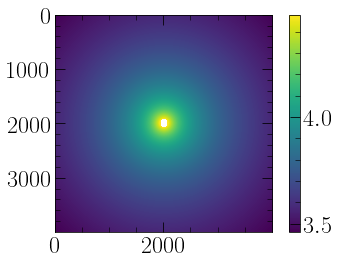

In [2]:
MEXP = 7.0
mass = 10**MEXP * const.M_sun.to(u.kg)
numGRs = 2000
rg = QMF.CalcRg(mass)
xvals = np.linspace(-numGRs, numGRs, 4000)
yvals = xvals.copy()
XV, YV = np.meshgrid(yvals, xvals)
Rmap = (XV**2 + YV**2)**0.5
Temp = QMF.AccDiskTemp(Rmap*rg, 50 * rg, mass, 3424, eddingtons=0.15) # eddingtons overwrites M_dot (defined fictionally here as 3424), setting R_in to be large
Vmap = np.zeros(np.shape(Temp))
Gmap = np.ones(np.shape(Temp))
        
image = plt.imshow(np.log10(Temp))
plt.colorbar(image)

In [3]:
redshift = 2.0
inc_angle = 0


In [4]:
DiskModel = Amoeba.ThinDisk(MEXP,redshift,numGRs, inc_angle,50, Temp,Vmap,Gmap,Rmap,name='Testing')

/usr/local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-5-3f8c10d5f26b>:10: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(x), np.log10(temps0))
<ipython-input-5-3f8c10d5f26b>:11: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(x), np.log10(temps1))


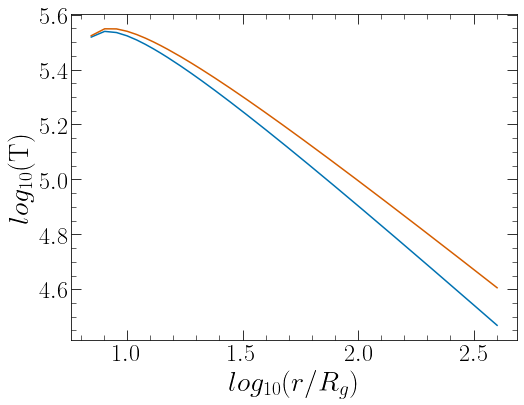

In [5]:
x = np.linspace(1, 400, 400)
temps0 = np.zeros(np.shape(x))
temps1 = np.zeros(np.shape(x))
M_acc = const.M_sun/u.yr
for jj in x:
    temps0[int(jj-1)] = QMF.AccDiskTemp(jj*QMF.CalcRg(mass), 6*QMF.CalcRg(mass), mass, M_acc)
    temps1[int(jj-1)] = QMF.AccDiskTemp(jj*QMF.CalcRg(mass), 6*QMF.CalcRg(mass), mass, M_acc, beta=0.3)
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.log10(x), np.log10(temps0))
ax.plot(np.log10(x), np.log10(temps1))
ax.set_xlabel(r"$log_{10}(r/R_{g})$")
ax.set_ylabel(r"$log_{10}$(T)")

plt.show()




In [6]:
BrightnessMap = DiskModel.MakeSurfaceIntensityMap(2000)

/Users/henrybest/PythonStuff/Code/Amoeba.py:78: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5


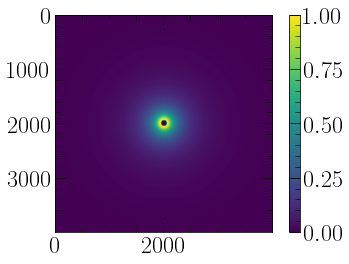

In [7]:
image2 = plt.imshow((BrightnessMap)/np.max(BrightnessMap))
plt.colorbar(image2)

In [8]:
DerMap = DiskModel.MakeDBDTMap(400)

/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5


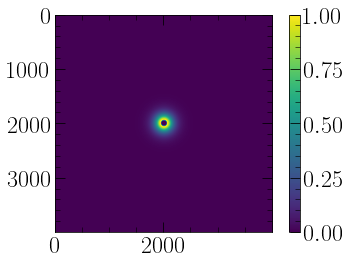

In [9]:
image3 = plt.imshow(DerMap/np.max(DerMap))
plt.colorbar(image3)

In [10]:
print(DiskModel.mass)
print(DiskModel.pxsize)
print(DiskModel.lum_dist)
print(DiskModel.mass)
print(DiskModel.mass_exp)
print(DiskModel.inc_ang)

1.988409870698051e+37 kg
14766250380.50125
4.7998728649502045e+26 m
1.988409870698051e+37 kg
7.0
0


<ipython-input-11-cc340e364e8d>:10: RuntimeWarning: divide by zero encountered in log10
  img2 = ax[1].imshow(np.log10(geomap/np.max(geomap)))


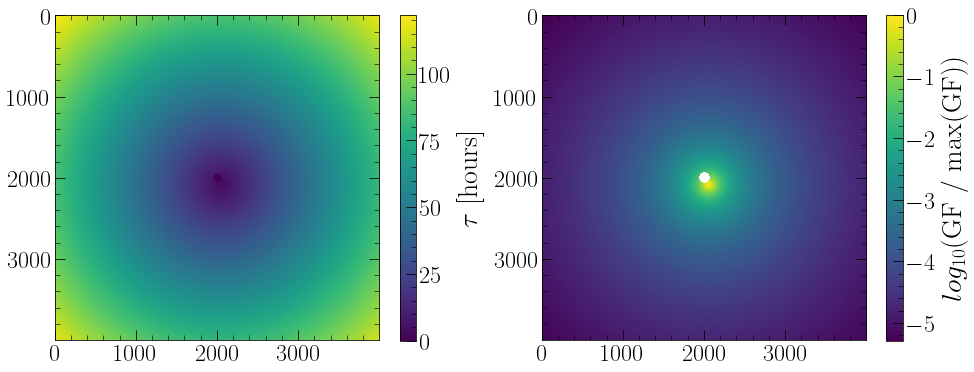

In [11]:
cheight = 50   #units R_g
axisoffset = 100  # units R_g
angleoffset = 30 # units deg, 0 is towards observer, phi increases counter-clockwise
delaymap = DiskModel.MakeTimeDelayMap(coronaheight=cheight, axisoffset=axisoffset, angleoffset=angleoffset)
geomap = QMF.ConstructGeometricDiskFactor(DiskModel.MakeDBDTMap(300), DiskModel.inc_ang, 
                        DiskModel.mass, DiskModel.c_height, numGRs=2*DiskModel.numGRs, albedo=0, 
                        axisoffset=axisoffset, angleoffset=angleoffset)
fig, ax = plt.subplots(1,2, figsize=(16,6))
img = ax[0].imshow(delaymap)
img2 = ax[1].imshow(np.log10(geomap/np.max(geomap)))
plt.colorbar(img, ax=ax[0], label=r"$\tau$ [hours]")
plt.colorbar(img2, ax=ax[1], label=r'$log_{10}$(GF / max(GF))') # GF = Geometric Factor--independent of surface temp

/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5


Text(0, 0.5, 'Response [arb.]')

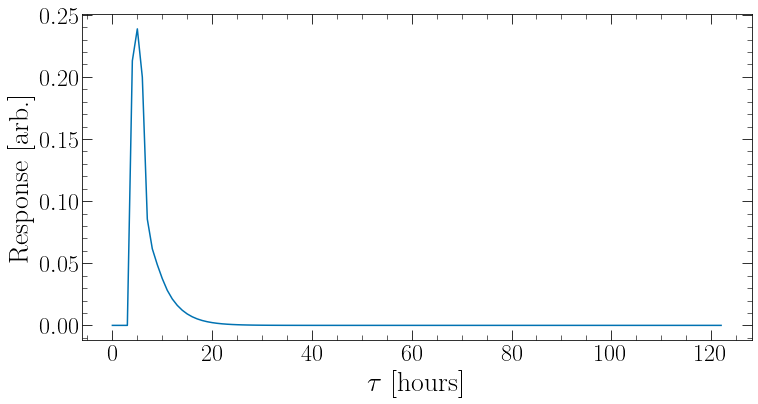

In [12]:
tf = DiskModel.ConstructDiskTransferFunction(400, coronaheight=cheight, axisoffset=axisoffset, 
                                             angleoffset=angleoffset, units='hours')
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tf[:500])
ax.set_xlabel(r"$\tau$ [hours]")
ax.set_ylabel("Response [arb.]")

In [13]:
magdir = '/Users/henrybest/PythonStuff/LensingMaps/image_2237_b_zoom2.fits'
MagnificationMap = Amoeba.MagnificationMap(2.0, 1.0, magdir, 0.38, 0.42, n_einstein=1)

10000
0.7965659850229427
6.03552298
603552298.0


In [14]:
print(MagnificationMap.name)
print(MagnificationMap.zq)
print(MagnificationMap.zl)
print(MagnificationMap.file_name)
print(MagnificationMap.m_lens)
print(MagnificationMap.resolution)
print(MagnificationMap.ray_to_mag_ratio)



2.0
1.0
/Users/henrybest/PythonStuff/LensingMaps/image_2237_b_zoom2.fits
1.988409870698051e+30 kg
10000
0.7965659850229427


<ipython-input-15-162c28278094>:2: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(MagnificationMap.mag_map))


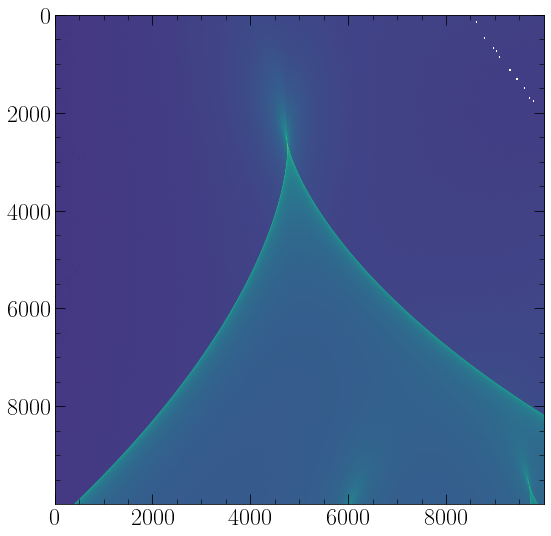

In [15]:
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(np.log(MagnificationMap.mag_map))

In [16]:
convolution1 = MagnificationMap.Convolve(DiskModel,400)              # Method based
convolution2 = Amoeba.ConvolvedMap(MagnificationMap, DiskModel, 400) # Class based


/Users/henrybest/PythonStuff/Code/Amoeba.py:78: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5


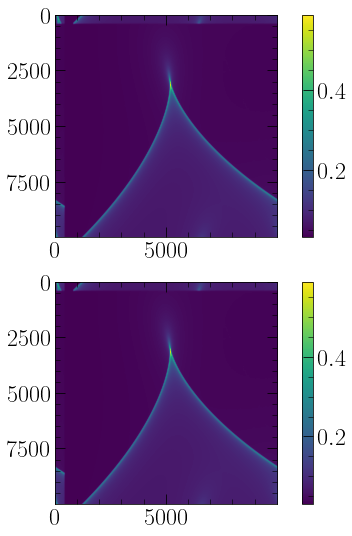

In [17]:
fig, ax = plt.subplots(2, figsize=(9,9))
vals = ax[0].imshow(np.nan_to_num(convolution1[0].real))
vals2 = ax[1].imshow((convolution2.mag_map))
fig.colorbar(vals, ax = ax[0])
fig.colorbar(vals2, ax = ax[1])

# Note the regions on the convolution which we must avoid! 
# Edge artifacts are avoided by consolidating the range to the central portion.
# A factor, px_shift, internally adjusts input positions to match between the magnification map and convolutions

In [18]:
print(DiskModel.pxsize)
print(MagnificationMap.px_size)
print(convolution2.px_size)
print(convolution2.px_shift)


14766250380.50125
34532227447.89353
34532227447.89353 m
427


pixel shift: 427 pixels


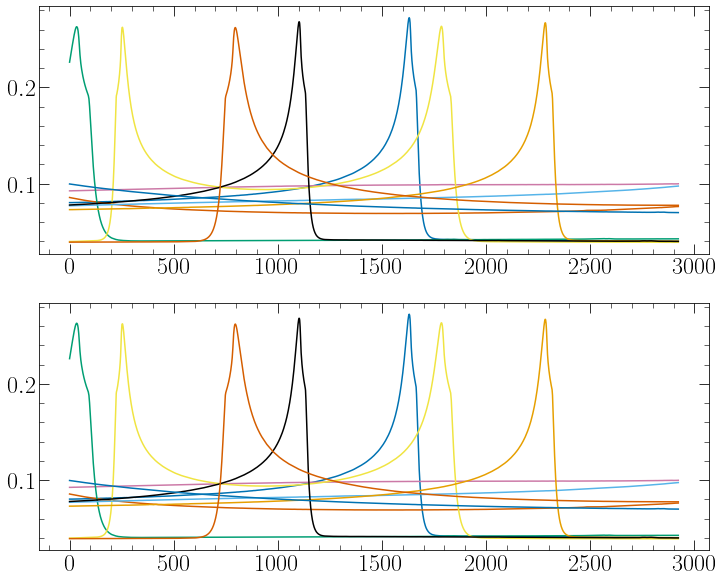

In [19]:
seednum = 100  # Reproduce with both methods

random.seed(seednum)
fig, ax = plt.subplots(2, figsize=(12, 10))
print("pixel shift: "+str(convolution1[2])+" pixels")

for jj in range(10):
    LC = QMF.PullLC(convolution1[0].real, convolution1[1], 800, 4, px_shift=convolution1[2]) # px_shift is required!
    ax[0].plot(LC)
    
random.seed(seednum)
for jj in range(10):
    LC = convolution2.PullLightCurve(800, 4)
    ax[1].plot(LC)

plt.show()
    

In [20]:
fnames = glob.glob("/Users/henrybest/PythonStuff/Code/SpinTest/*")
for jj in range(len(fnames)):
    print(fnames[jj])
    print(fnames[jj][-9:-5])
    with fits.open(fnames[jj]) as f:
        v1 = f[0].header['v1']
        v2 = f[0].header['v2']
        v3 = f[0].header['v3']
        v4 = f[0].header['v4']
        m1 = f[0].data
        m2 = f[1].data
        m3 = f[2].data
        m4 = f[3].data
    if fnames[jj][-9:-5]=="t0.0":
        disk1 = Amoeba.ThinDisk(v1, v2, v3, v4, 6, m1, m2, m3, m4*QMF.CalcRg(10**v1*const.M_sun.to(u.kg)))
    elif fnames[jj][-9:-5]=="t0.5":
        disk2 = Amoeba.ThinDisk(v1, v2, v3, v4, 6, m1, m2, m3, m4*QMF.CalcRg(10**v1*const.M_sun.to(u.kg)), spin=0.5) 
    elif fnames[jj][-9:-5]=="t0.8":
        disk3 = Amoeba.ThinDisk(v1, v2, v3, v4, 6, m1, m2, m3, m4*QMF.CalcRg(10**v1*const.M_sun.to(u.kg)), spin=0.8) 
    elif fnames[jj][-9:-5]=="t0.9":
        disk4 = Amoeba.ThinDisk(v1, v2, v3, v4, 6, m1, m2, m3, m4*QMF.CalcRg(10**v1*const.M_sun.to(u.kg)), spin=0.9) 
    elif fnames[jj][-9:-5]=="m0.5":
        diskm2 = Amoeba.ThinDisk(v1, v2, v3, v4, 6, m1, m2, m3, m4*QMF.CalcRg(10**v1*const.M_sun.to(u.kg)), spin=-0.5) 
    elif fnames[jj][-9:-5]=="m0.8":
        diskm3 = Amoeba.ThinDisk(v1, v2, v3, v4, 6, m1, m2, m3, m4*QMF.CalcRg(10**v1*const.M_sun.to(u.kg)), spin=-0.8) 
    elif fnames[jj][-9:-5]=="m0.9":
        diskm4 = Amoeba.ThinDisk(v1, v2, v3, v4, 6, m1, m2, m3, m4*QMF.CalcRg(10**v1*const.M_sun.to(u.kg)), spin=-0.9) 


/Users/henrybest/PythonStuff/Code/SpinTest/DecemberSpinTest0.8.fits
t0.8
/Users/henrybest/PythonStuff/Code/SpinTest/DecemberSpinTest0.9.fits
t0.9
/Users/henrybest/PythonStuff/Code/SpinTest/DecemberSpinTest0.5.fits
t0.5
/Users/henrybest/PythonStuff/Code/SpinTest/DecemberSpinTestm0.5.fits
m0.5
/Users/henrybest/PythonStuff/Code/SpinTest/DecemberSpinTestm0.9.fits
m0.9
/Users/henrybest/PythonStuff/Code/SpinTest/DecemberSpinTest0.0.fits
t0.0
/Users/henrybest/PythonStuff/Code/SpinTest/DecemberSpinTestm0.8.fits
m0.8


In [21]:
print(disk1.pxsize/disk1.rg)

0.5


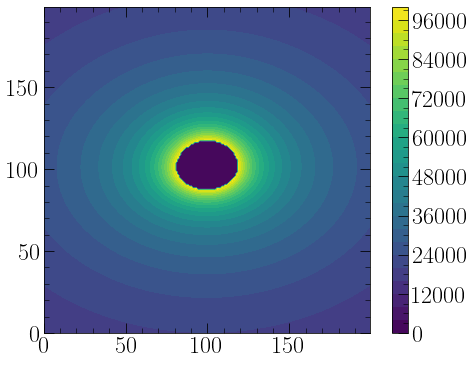

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
conts = ax.contourf((diskm3.temp_map), 30) #Temperature Map
ax.set_aspect(1)
plt.colorbar(conts, ax=ax)
plt.show()

In [23]:
BrightnessMap1, wavelengths= disk1.MakeSurfaceIntensityMap(800, returnwavelengths=True)
BrightnessMap2= disk2.MakeSurfaceIntensityMap(800)
BrightnessMap3= disk3.MakeSurfaceIntensityMap(800)
BrightnessMap4= disk4.MakeSurfaceIntensityMap(800)
BrightnessMapm2= diskm2.MakeSurfaceIntensityMap(800)
BrightnessMapm3= diskm3.MakeSurfaceIntensityMap(800)
BrightnessMapm4= diskm4.MakeSurfaceIntensityMap(800)


/Users/henrybest/PythonStuff/Code/Amoeba.py:78: RuntimeWarning: divide by zero encountered in true_divide
  gravshiftfactor = (1 - event_horizon/radius)**0.5
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 * h.value * c.value * (lam)**(-3.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input


<ipython-input-24-16d9208131b7>:6: RuntimeWarning: divide by zero encountered in log10
  conts1 = ax[0,0].contourf(np.log10(BrightnessMap1[lower:upper,lower:upper]))
<ipython-input-24-16d9208131b7>:7: RuntimeWarning: divide by zero encountered in log10
  conts1 = ax[0,1].contourf(np.log10(BrightnessMap1[lower:upper,lower:upper]))
<ipython-input-24-16d9208131b7>:9: RuntimeWarning: divide by zero encountered in log10
  conts2 = ax[1,0].contourf(np.log10(BrightnessMap2[lower:upper,lower:upper]))
<ipython-input-24-16d9208131b7>:10: RuntimeWarning: divide by zero encountered in log10
  contsm2 = ax[1,1].contourf(np.log10(BrightnessMapm2[lower:upper,lower:upper]))
<ipython-input-24-16d9208131b7>:12: RuntimeWarning: divide by zero encountered in log10
  conts3 = ax[2,0].contourf(np.log10(BrightnessMap3[lower:upper,lower:upper]))
<ipython-input-24-16d9208131b7>:13: RuntimeWarning: divide by zero encountered in log10
  contsm3 = ax[2,1].contourf(np.log10(BrightnessMapm3[lower:upper,lower:upper]

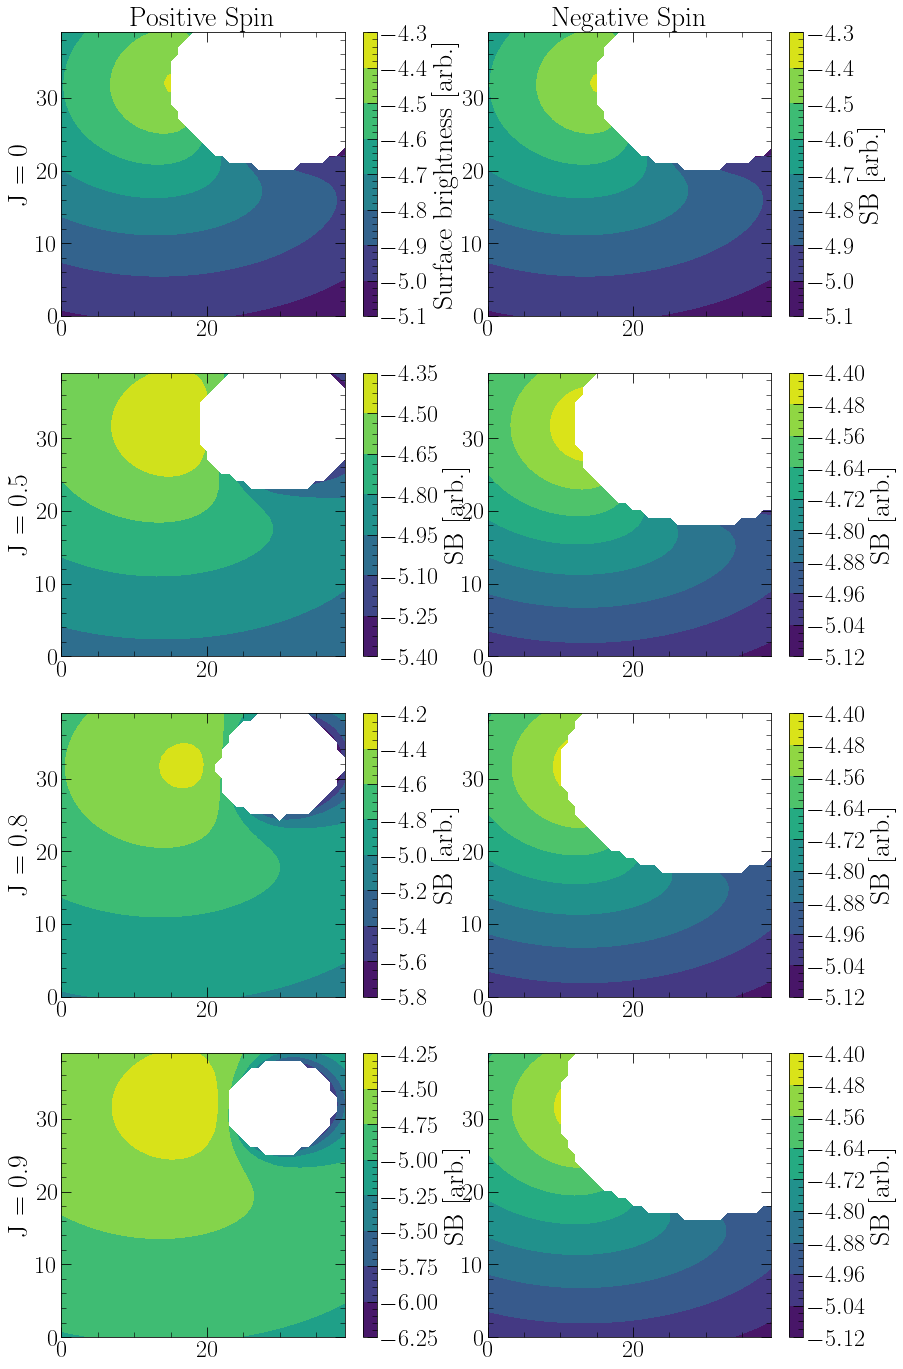

In [24]:
fig, ax = plt.subplots(4,2, figsize=(14,24))

lower=70
upper=110

conts1 = ax[0,0].contourf(np.log10(BrightnessMap1[lower:upper,lower:upper]))
conts1 = ax[0,1].contourf(np.log10(BrightnessMap1[lower:upper,lower:upper]))

conts2 = ax[1,0].contourf(np.log10(BrightnessMap2[lower:upper,lower:upper]))
contsm2 = ax[1,1].contourf(np.log10(BrightnessMapm2[lower:upper,lower:upper]))

conts3 = ax[2,0].contourf(np.log10(BrightnessMap3[lower:upper,lower:upper]))
contsm3 = ax[2,1].contourf(np.log10(BrightnessMapm3[lower:upper,lower:upper]))

conts4 = ax[3,0].contourf(np.log10(BrightnessMap4[lower:upper,lower:upper]))
contsm4 = ax[3,1].contourf(np.log10(BrightnessMapm4[lower:upper,lower:upper]))

plt.colorbar(conts1, ax=ax[0,0], label="Surface brightness [arb.]")
plt.colorbar(conts1, ax=ax[0,1], label='SB [arb.]')
plt.colorbar(conts2, ax=ax[1,0], label='SB [arb.]')
plt.colorbar(conts3, ax=ax[2,0], label='SB [arb.]')
plt.colorbar(conts4, ax=ax[3,0], label='SB [arb.]')
plt.colorbar(contsm2, ax=ax[1,1], label='SB [arb.]')
plt.colorbar(contsm3, ax=ax[2,1], label='SB [arb.]')
plt.colorbar(contsm4, ax=ax[3,1], label='SB [arb.]')

ax[0,0].set_aspect(1)
ax[1,0].set_aspect(1)
ax[2,0].set_aspect(1)
ax[3,0].set_aspect(1)
ax[0,1].set_aspect(1)
ax[1,1].set_aspect(1)
ax[2,1].set_aspect(1)
ax[3,1].set_aspect(1)

ax[0,0].set_title("Positive Spin")
ax[0,1].set_title("Negative Spin")
ax[0,0].set_ylabel("J = 0")
ax[1,0].set_ylabel("J = 0.5")
ax[2,0].set_ylabel("J = 0.8")
ax[3,0].set_ylabel("J = 0.9")


plt.show()

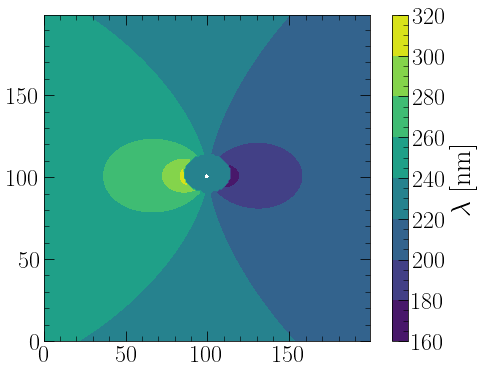

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
conts = ax.contourf((wavelengths))
ax.set_aspect(1)
plt.colorbar(conts, ax=ax, label=r"$\lambda$ [nm]")
plt.show()

/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: divide by zero encountered in true_divide
  gravshiftfactor = (1 - event_horizon/radius)**0.5
/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: overflow encountered in power
  return (2.0 * h.value * c.value * (lam)**(-3.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input


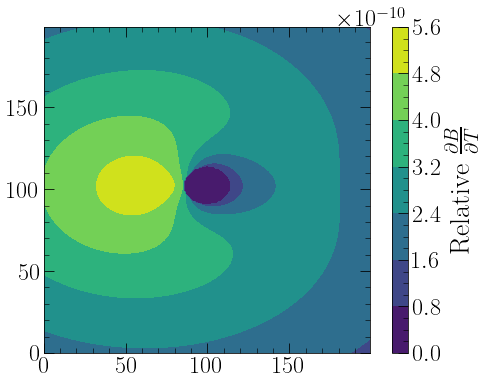

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
ReprocessMap = disk1.MakeDBDTMap(800)
conts = ax.contourf(ReprocessMap)
ax.set_aspect(1)
plt.colorbar(conts, ax=ax, label=r"Relative $\frac{\partial B}{\partial T}$")
plt.show()

In [27]:
TF1 = disk1.ConstructDiskTransferFunction(400)
# Note, this transfer function is not complete due to the disk only being calculated out to 50 Rg

/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: divide by zero encountered in true_divide
  gravshiftfactor = (1 - event_horizon/radius)**0.5
/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 * h.value * c.value * (lam)**(-3.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: overflow encountered in power
  return (2.0 * h.value * c.value * (lam)**(-3.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:518: Runtime

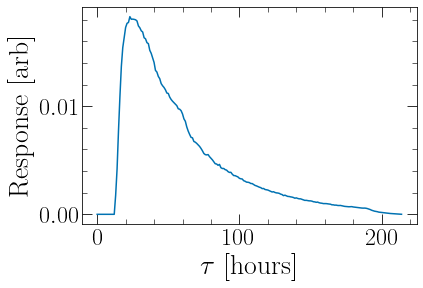

In [28]:
lim=2400
fig, ax = plt.subplots()
ax.plot(TF1[:lim])
ax.set_xlabel(r"$\tau$ [hours]")
ax.set_ylabel("Response [arb]")
plt.show()

In [29]:
fnames = glob.glob("/Users/henrybest/PythonStuff/ExampleAmoebaTFs/9.9*")
#fnames = ['/Users/henrybest/PythonStuff/ExampleAmoebaTFs/8.001m0.0672.67.fits']
#for jj in range(len(fnames)):
#    print(jj, fnames[jj])


In [30]:
num = random.randint(np.size(fnames))
print(num)
with fits.open(fnames[num]) as f:
    data = f[0].data
    header = f[0].header

13


In [31]:
print(fnames[num])
header

/Users/henrybest/PythonStuff/ExampleAmoebaTFs/9.905p0.7045.940.528.fits


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                14381                                                  
NAXIS2  =                    6                                                  
EXTEND  =                    T                                                  
MASS    =    9.905128228968341                                                  
SPIN    =   0.7065934084011838                                                  
INC_ANG =    45.94882088729921                                                  
Z_Q     =    4.632875614212717                                                  
BETA    =    0.528423250051408                                                  
CHEIGHT =     3.90040837199517                                                  
UNITS   = 'days    '        

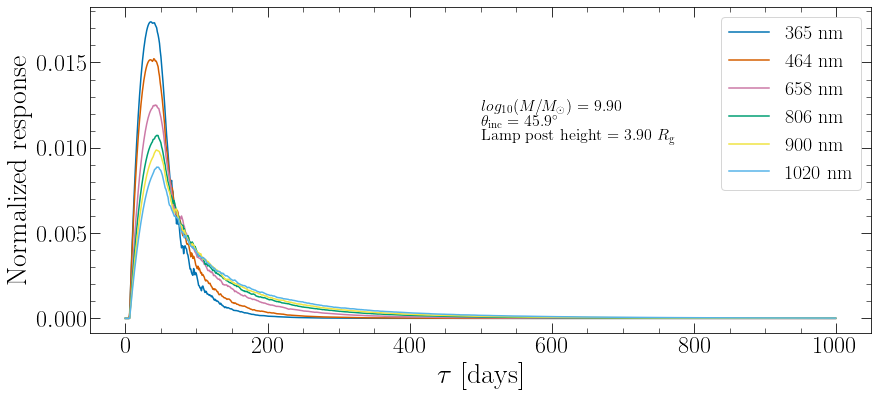

In [32]:
plt.style.use("plot_style_large_font.txt")
fig, ax = plt.subplots(figsize=(14, 6))
plt.rc('font', size=16)
plt.rc('axes', titlesize=14)     
plt.rc('axes', labelsize=14)      
plt.rc('figure', titlesize=16)
lim=1000#len(data[0,:])
labels = ['365 nm','464 nm','658 nm','806 nm','900 nm','1020 nm']
for ii in range(6):
    plt.plot((data[ii, :lim]),label=labels[ii])
#ax.set_title("Index "+str(num)+", with weighting factor")
ax.text(0.5*len(data[0, :lim]), 0.7*np.max((data[0,:lim])), r"$log_{10}(M/M_{\odot})$ = "+str(header["mass"])[:4])
ax.text(0.5*len(data[0, :lim]), 0.65*np.max(data[0,:lim]), r"$\theta_{\rm{inc}} = "+str(header["inc_ang"])[:4]+r"^{\circ}$")
ax.text(0.5*len(data[0, :lim]), 0.60*np.max(data[0,:lim]), r"Lamp post height = "+str(header['cheight'])[:4]+r" $R_{\rm{g}}$")
if header['units'] == 'hours':
    ax.set_xlabel(r"$\tau$ [hours]")
elif header['units'] == 'days':
    ax.set_xlabel(r"$\tau$ [days]")
ax.set_ylabel("Normalized response")
ax.legend()
plt.show()
#fig.savefig("ExampleTFs.png")

In [33]:
print(np.sum(data))  # Showing that it's normalized in each band--1+1+1+1+1+1 = 6

6.000000000000001


In [41]:
ExampleFnames = glob.glob("/Users/henrybest/PythonStuff/ExampleAmoebaDisks/8.0*")

In [42]:
filenum = random.randint(np.size(ExampleFnames))
filename = ExampleFnames[filenum]
with fits.open(filename) as f:
    print(np.shape(f))
    datatemp = f[0].data
    datavel = f[1].data
    datag = f[2].data
    datar = f[3].data
    header = f[0].header
print(filenum)
header

(4,)
52


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1000                                                  
NAXIS2  =                 1000                                                  
EXTEND  =                    T                                                  
MASS    =    8.062946668564992                                                  
ZQ      =    5.173713062494251                                                  
SPIN    =   0.8717313773629198                                                  
INC_ANG =     5.55246418808144                                                  
C_HEIGHT=     22.4872283876343                                                  
BETA    =   0.5776155090340849                                                  

In [43]:
SampleDisk = Amoeba.ThinDisk(header['mass'], header['zq'], 1000, header['inc_ang'], header['c_height'], datatemp, datavel, datag, datar, spin=header['spin'])

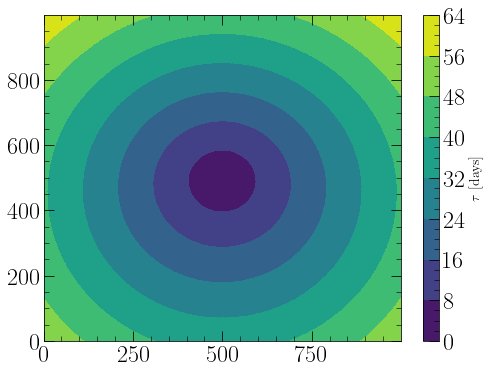

In [44]:
fig, ax = plt.subplots(figsize=(8,6))
conts = ax.contourf(SampleDisk.MakeTimeDelayMap(5, unit='days'))
cbar = plt.colorbar(conts, ax=ax, label=r"$\tau$ [days]")

In [50]:
unit_choice = 'hours'
SampleTF1 = SampleDisk.ConstructDiskTransferFunction(510, units=unit_choice)
SampleTF2 = SampleDisk.ConstructDiskTransferFunction(1760, units=unit_choice)

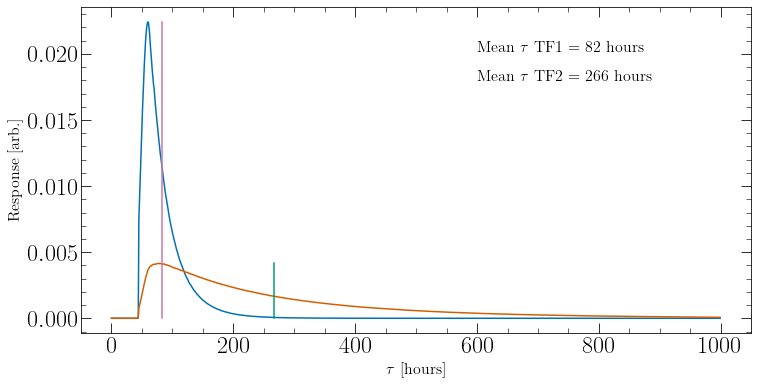

In [51]:
lim = 1000
mean1 = np.sum(SampleTF1 * np.linspace(0, len(SampleTF1), len(SampleTF1)))
mean2 = np.sum(SampleTF2 * np.linspace(0, len(SampleTF2), len(SampleTF2)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(SampleTF1[:lim])
ax.plot(SampleTF2[:lim])
ax.plot([mean1, mean1], [0, np.max(SampleTF1)])
ax.plot([mean2, mean2], [0, np.max(SampleTF2)])
ax.text(0.6*min(lim, len(SampleTF1)), 0.9*np.max(SampleTF1), r"Mean $\tau$ TF1 = "+str(int(mean1))+' '+unit_choice)
ax.text(0.6*min(lim, len(SampleTF1)), 0.8*np.max(SampleTF1), r"Mean $\tau$ TF2 = "+str(int(mean2))+' '+unit_choice)
ax.set_xlabel(r"$\tau$ ["+unit_choice+"]", fontsize=16)
ax.set_ylabel("Response [arb.]", fontsize=16)
plt.show()